# T07.01 - Smoothing and Noise Reduction

## ANGGOTA KELOMPOK


1.   Elmir Yasakha - 442303611058
2.   HIkam Ibnu - 442303611044
3.   M Rizqi Anugrah - 442303611041
4.   Dziffar J - 442303611055
5.   Arifin Zulfan - 442303611043
6.   Rahmat Abdurrahman - 442023611047


In [1]:
!pip install -q kaggle

from google.colab import files
import os

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset
!unzip -q road-accidents-from-cctv-footages-dataset.zip -d road_accidents_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset
License(s): MIT
 94% 627M/670M [00:03<00:00, 210MB/s]
100% 670M/670M [00:03<00:00, 206MB/s]


In [12]:
# Import library yang dibutuhkan
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


image_path = '/content/road_accidents_dataset/Accident/Accident/1.jpg'

# Memuat citra asli yang bersih
clean_original_image = cv2.imread(image_path)

# Konversi ke grayscale untuk diolah
clean_gray_image = cv2.cvtColor(clean_original_image, cv2.COLOR_BGR2GRAY)

# Menambahkan Noise untuk Simulasi
def add_salt_pepper_noise(image, amount=0.05):
    noisy_image = np.copy(image)
    # Salt (bintik putih)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255
    # Pepper (bintik hitam)
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0
    return noisy_image

# Buat citra yang terganggu oleh noise dari citra bersih
noisy_image = add_salt_pepper_noise(clean_gray_image)

In [6]:
# Menerapkan Median Filter
kernel_size = 5
median_filtered = cv2.medianBlur(noisy_image, kernel_size)

# Menerapkan Bilateral Filter. Filter ini mempertimbangkan jarak spasial dan perbedaan intensitas piksel. Ini membuatnya mampu mengurangi noise sambil menjaga ketajaman tepi.

d = 9                       # d: Diameter lingkungan piksel.
sigmaColor = 75             # sigmaColor: Semakin besar, semakin banyak warna yang dianggap mirip.
sigmaSpace = 75             # sigmaSpace: Semakin besar, semakin jauh piksel yang akan saling mempengaruhi.
bilateral_filtered = cv2.bilateralFilter(noisy_image, d, sigmaColor, sigmaSpace)

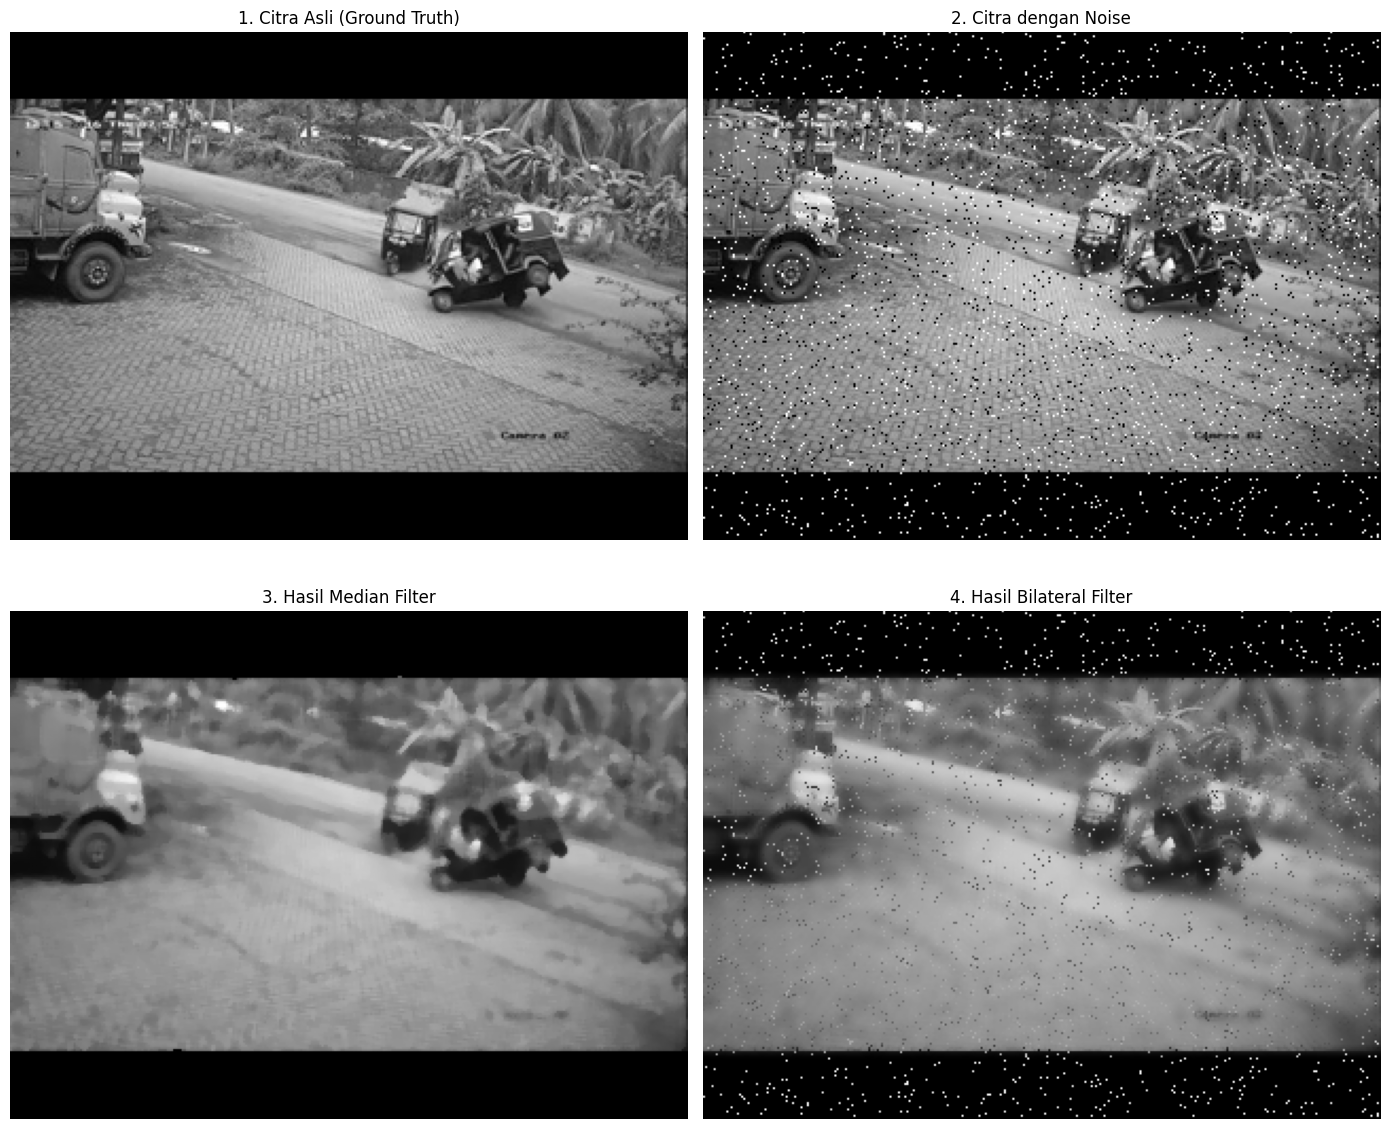

In [10]:
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Citra Asli
axes[0, 0].imshow(clean_gray_image, cmap='gray')
axes[0, 0].set_title('1. Citra Asli (Ground Truth)')
axes[0, 0].axis('off')

# 2. Citra dengan Noise
axes[0, 1].imshow(noisy_image, cmap='gray')
axes[0, 1].set_title('2. Citra dengan Noise')
axes[0, 1].axis('off')

# 3. Hasil Median Filter
axes[1, 0].imshow(median_filtered, cmap='gray')
axes[1, 0].set_title('3. Hasil Median Filter')
axes[1, 0].axis('off')

# 4. Hasil Bilateral Filter
axes[1, 1].imshow(bilateral_filtered, cmap='gray')
axes[1, 1].set_title('4. Hasil Bilateral Filter')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
# metrik untuk Median Filter
psnr_median = psnr(clean_gray_image, median_filtered)
ssim_median = ssim(clean_gray_image, median_filtered, data_range=median_filtered.max() - median_filtered.min())

# metrik untuk Bilateral Filter
psnr_bilateral = psnr(clean_gray_image, bilateral_filtered)
ssim_bilateral = ssim(clean_gray_image, bilateral_filtered, data_range=bilateral_filtered.max() - bilateral_filtered.min())

# Tampilkan hasil
print("HASIL EVALUASI KUANTITATIF")
print(f"Median Filter:")
print(f"PSNR: {psnr_median:.2f} dB")
print(f"SSIM: {ssim_median:.4f}")
print("\n")
print(f"Bilateral Filter:")
print(f"PSNR: {psnr_bilateral:.2f} dB")
print(f"SSIM: {ssim_bilateral:.4f}")

HASIL EVALUASI KUANTITATIF
Median Filter:
PSNR: 24.48 dB
SSIM: 0.6574


Bilateral Filter:
PSNR: 20.17 dB
SSIM: 0.4485


# Analisis/Diskusi Kritis


*  ##  Evaluasi Visual
    1.  Median Filter menghilangkan hampir semua bintik-bintik noise. Ini terjadi karena mekanisme dasarnya yang mengambil nilai median (nilai tengah) dari piksel di sekitarnya. Nilai ekstrem seperti bintik hitam pekat (nilai ≈ 0) dan putih pekat (nilai ≈ 255) secara efektif diabaikan karena dianggap sebagai outlier. Hasilnya adalah citra yang bersih, meskipun dengan konsekuensi gambar menjadi sedikit lebih halus atau kabur.
    2. Bilateral Filter tidak cocok untuk jenis noise ini. Fungsi utama filter ini adalah mengurangi noise sambil melestarikan tepi (edge-preserving). Filter ini menganggap bintik noise yang memiliki kontras sangat tinggi sebagai tepi yang harus dilestarikan. Akibatnya, filter ini justru gagal membersihkan noise dan hanya sedikit mengaburkan area di sekitar noise tersebut.

*  ##  Evaluasi Kuantitatif
    1. Nilai Median Filter (24.48 dB) yang jauh lebih tinggi dibandingkan Bilateral Filter (20.17 dB) membuktikan bahwa secara matematis, citra hasil Median Filter memiliki tingkat kesalahan (error) piksel yang jauh lebih rendah jika dibandingkan dengan citra asli.
    2. Sebaliknya, SSIM Bilateral Filter yang rendah (0.4485) mengonfirmasi bahwa keberadaan noise yang pekat telah merusak kemiripan struktural citra
